In [4]:
import sys
import os
sys.path.append('c:\\Users\\nkwan\\Desktop\\school\\capstone\\code\\legume')

In [5]:
import numpy as np
import legume
import chickpea
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mode Volume and Normalization

Another important factor in the performance of a photonic crystal cavity is its mode volume. The `CavityModeAnalysis` class provides a method for finding the mode volume, based on a sampling rate. To see how this is used, we initialize an H2 crystal, as before.

In [8]:
Nx, Ny = 16, 16

#we can modify this to suit our needs
thickness = 0.71
eps = 11.56
rad = 0.37
cavType = 'H'
n = 2

crystal = chickpea.PhotonicCrystalCavity(crystal = cavType, n=n, supercell_size = (Nx, Ny), thickness = thickness, radius = rad, eps = eps)
phc = crystal.cavity()
base = crystal.get_base_crystal()

In [9]:
defectMargins = np.array([0.25, 0.25])
cma = CavityModeAnalysis(phc, base, defectMargins, layer=0, gmax=2, base_gmax=3)
#using this method places some constraints on the parameters

[0.41164399]
Band gap lower bound: 0.276774.
Band gap upper bound: 0.420233.
Band gap center: 0.348504.
Gap-midgap ratio: 0.411644.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



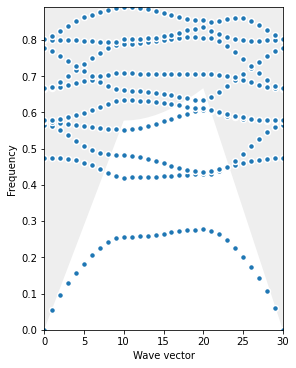

In [10]:
bandgaps, k_air, k_eps = cma.find_band_gaps(band_tol = 0.1, order=np.array([0]), trim_lc = True, lc_trim = 0.04, numeig=10)

gmg_ratio = np.array([(bandgap[1]-bandgap[0]) / bandgap[2] for bandgap in bandgaps])
legume.viz.bands(cma.base_gme, trim_light_cone = False, lc_trim = 0.04)
print(gmg_ratio)

print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (bandgaps[0][0], bandgaps[0][1], bandgaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))



In [13]:
options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'eig_solver': 'eigh',
           'numeig': 30,
           'eig_sigma': bandgaps[0][2],
           'compute_im': False
}
kpoints = np.array([[k_air[0][0]], [k_air[1][0]]])
cma.gme.run(kpoints=kpoints, **options)

Running k-point 1 of 1

MemoryError: Unable to allocate 97.5 MiB for an array with shape (3575, 3575) and data type float64

Below is the code used for the mode_volume method in the cma class, with a couple of added inputs to get rid of references to class attributes.

In [ ]:
def mode_volume(gme, dslab, field, components, kind, mind, l_x, l_y, marg_x, marg_y, sample_scale=2):
    """
    Get the Max
    """
    s_nx = int(sample_scale * l_x)
    s_ny = int(sample_scale * l_y)

    fields, _, _ = gme.get_field_xy(field=field, kind=kind, mind=mind, z=dslab / 2, component=components, Nx=s_nx, Ny=s_ny)

    field = np.zeros((s_ny, s_nx))
    for component in components:
        field = field + np.abs(fields[component]) ** 2

    field = field ** (1 / 2)

    defect_field = np.abs(field[int(marg_y * s_ny): -int(marg_y * s_ny),
                              int(marg_x * s_nx): -int(marg_x * s_nx)])

    mode_volume = 1 / np.square(np.amax(defect_field))

    return mode_volume

In effect, this method works by sampling the desired field and taking the reciprocal of the square of the largest field magnitude sampled in the defect region. Notice that no integration is done because the fields and eigenvectors are normalized to 1. 

It's important to define the defect margins and sample rate such that the resulting mode volume is accurate. For instance, if the sample rate is too low, and the mode isn't a monopole mode, we may not get accurate results. Let's repeat what we did in notebook 2 to get some mode profiles. The cma method `filter_for_defect_mode` returns:
- A list of pairs corresponding to defect modes, where the first element is a k index and the second element is a list of m indices corresponding to that k index
- Mode volumes, with a sample_scale of 2, for the defect modes.

To see how mode volume is a function of sample scale, we initialize an array of sample scales.

In [ ]:
arg_list, v = cma.filter_for_defect_mode(max_volume = 5, band_filter = bandgaps)

#im not able to run this locally cuz my computer is wack.

ss_low = 0.5
ss_high = 2.5
ss_step = 0.2
sample_scales = np.arange(ss_low, ss_high, ss_step)

Recall that the mode at PUT MODE INFO HERE isn't a monopole mode. Let's see what happens when its mode volume is calculated over our previously initialized sample scale array

In [ ]:
kind_nm = #PUT K INDEX OF NON MONOPOLE MODE HERE
mind_nm = #M INDEX HERE

volumes = []
for ss in sample_scales:
    vol = cma.mode_volume(cma.gme, field='E', components='z', kind = kind_nm, mind = mind_nm, ss)
    volumes.append(vol)

plt.plot(sample_scales, volumes)
plt.xlabel('sample scales')
plt.ylabel('mode volumes')
plt.title('mode volume for the mode at k='+ str(kind)+ ', m=' + str(mind) + ' as a function of sample scale')
plt.show()

As we can see, for lower sample scales, the mode volume returned isn't accurate. Now, let's look at another particular mode

In [ ]:
kind_nd = #PUT K INDEX OF NON DEFECT MODE HERE
mind_nd = #PUT M INDEX OF NON DEFECT MODE HERE

legume.viz.field(cma.gme, 'E', kind, mind, z=thickness/2, component='xy', val='abs')

Notice how this mode isn't a defect mode. Now, we can take its mode volume.

In [ ]:
volume = cma.mode_volume(cma.gme, 'E', 'z', kind=kind_nd, mind=mind_nd)
print("mode volume for non-defect mode: "+str(volume))

Despite this, the mode still has a low mode volume!

In conclusion, to use the cma class effectively get mode volume, we need to be careful with the defect margins we define, as well as the sample scale we use. We also have to be aware of potential non-defect modes with low mode volumes.